In [79]:
import procyclingstats as pcs
import pandas as pd

In [80]:
from typing import List, Tuple, Union
from procyclingstats.errors import UnexpectedParsingError
from procyclingstats.table_parser import TableParser


def parse(self, fields: Union[List[str], Tuple[str, ...]]) -> None:

    raw_table = []
    for _ in range(self.table_length):
        raw_table.append({})

    for field in fields:
        if field != "class":
            parsed_field_list = getattr(self, field)()
        # special case when field is called class
        else:
            parsed_field_list = getattr(self, "class_")()
        # field wasn't found in every table row, so isn't matching table
        # rows correctly
        if len(parsed_field_list) != self.table_length:
            message = f"Field '{field}' wasn't parsed correctly"
            raise UnexpectedParsingError(message)

        for row, parsed_value in zip(raw_table, parsed_field_list):
            row[field] = parsed_value

    # remove unwanted rows
    for row in raw_table:
        self.table.append(row)

    # if "time" in fields and self.table:
    # self._make_times_absolute()


TableParser.parse = parse

In [81]:
rider = pcs.Rider("rider/bruno-surra")
rider

Rider(url='https://www.procyclingstats.com/rider/bruno-surra')

In [82]:
df_races = pd.read_csv("dataset/races.csv")
df_races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

In [83]:
# get _url which have negative delta
bad_urls = df_races.loc[df_races["delta"] < 0, "_url"]
bad_urls = bad_urls.unique()

In [84]:
def time_to_seconds(time):
    h, m, s = time.split(":")
    h = int(h) * 3600
    m = int(m) * 60
    s = int(s)
    sign = -1 if m < 0 or h < 0 or s < 0 else 1
    return sign * (abs(h) + abs(m) + abs(s))

In [85]:
for RACE_URL in bad_urls:
    stage = pcs.Stage(f"race/{RACE_URL}")
    print(stage)
    ranking = stage.results("rider_url", "time", "rank")
    # for i in sorted(ranking,key = lambda x: x['rank']):
    #    print(i)

    # convert ranking to pandas table, ranking is a list of objects
    df_ranking = pd.DataFrame(ranking)

    df_ranking["time"] = df_ranking["time"].apply(time_to_seconds)

    # sum first time to all other negative times
    # first time is the time of the winner
    first_time = df_ranking["time"].loc[0]

    # sum first time to all other negative times
    df_ranking["time"] = df_ranking["time"].apply(
        lambda x: x if x > 0 else first_time + x
    )

    df_ranking.loc[0, "time"] = 0

    df_ranking.rider_url = df_ranking.rider_url.apply(
        lambda x: x.split("/")[-1]
    )

    for i in range(len(df_ranking)):
        rider = df_ranking.loc[i, "rider_url"]
        time = df_ranking.loc[i, "time"]

        df_races.loc[
            (df_races._url == RACE_URL) & (df_races.cyclist == rider),
            "delta",
        ] = time

    print(
        df_races.loc[
            (df_races._url == RACE_URL),
            "delta",
        ]
    )

Stage(url='https://www.procyclingstats.com/race/vuelta-a-espana/1992/stage-19')
70641      0.0
70642     52.0
70643     68.0
70644     93.0
70645    100.0
         ...  
70721    363.0
70722    369.0
70723    371.0
70724    372.0
70725    375.0
Name: delta, Length: 85, dtype: float64
Stage(url='https://www.procyclingstats.com/race/paris-nice/1990/stage-7a')
229663       0.0
229664      27.0
229665      27.0
229666      27.0
229667      27.0
229668      27.0
229669      27.0
229670      27.0
229671      27.0
229672    1371.0
Name: delta, dtype: float64
Stage(url='https://www.procyclingstats.com/race/tour-de-france/2003/stage-12')
413388      0.0
413389     96.0
413390    126.0
413391    160.0
413392    163.0
          ...  
413546    700.0
413547    727.0
413548    737.0
413549    738.0
413550    753.0
Name: delta, Length: 163, dtype: float64
Stage(url='https://www.procyclingstats.com/race/tour-de-suisse/1993/stage-4')
520734     0.0
520735    11.0
520736    58.0
520737    19.0
520738  

In [86]:
# check if delta contains positive floats
print(all(x.is_integer() for x in df_races.delta.dropna()))

True


In [87]:
# make consistent deltas with position
for stage in df_races._url.unique():
    df_stage = df_races.loc[df_races._url == stage]
    df_stage = df_stage.sort_values("position")
    df_stage.reset_index(drop=True, inplace=True)

    for i in range(len(df_stage) - 1):
        if (
            df_stage.loc[i, "delta"] > df_stage.loc[i + 1, "delta"]
        ):  # next position is faster
            if (
                df_stage.loc[i - 1, "delta"] <= df_stage.loc[i + 1, "delta"]
            ):  # next consistent with previous -> put as average
                df_races.loc[
                    (df_races._url == stage) & df_races.cyclist
                    == df_stage.loc[i, "cyclist"],
                    "delta",
                ] = df_stage.loc[i, "delta"] = round(
                    (
                        df_stage.loc[i - 1, "delta"]
                        + df_stage.loc[i + 1, "delta"]
                    )
                    / 2
                )
            else:  # next not consistent with previous -> put as present
                df_races.loc[
                    (df_races._url == stage) & df_races.cyclist
                    == df_stage.loc[i + 1, "cyclist"],
                    "delta",
                ] = df_stage.loc[i + 1, "delta"] = df_stage.loc[i, "delta"]

    # control every position has higher delta
    assert all(x <= y for x, y in zip(df_stage.delta, df_stage.delta[1:]))

Text(0, 0.5, 'Delta')

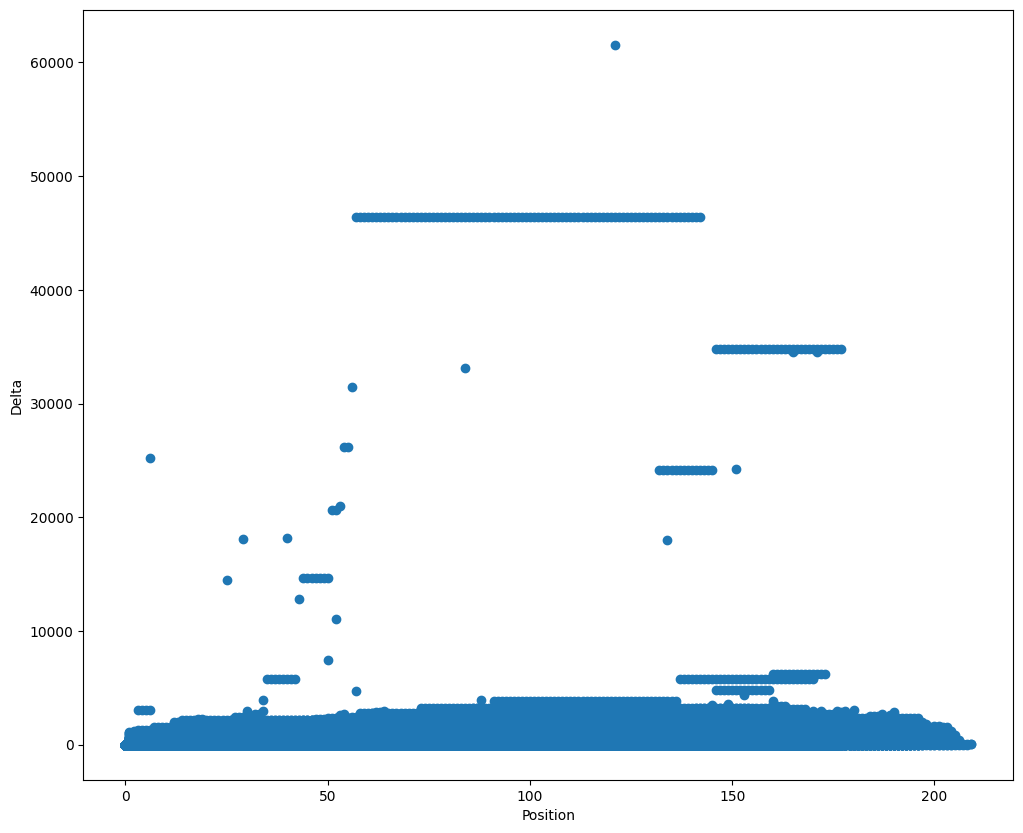

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.scatter(df_races['position'], df_races['delta'])
plt.xlabel('Position')
plt.ylabel('Delta')

## Teams imputation (scraping)

Try solving the imputation of teams

In [ ]:
# create a file for output
with open("output.txt", "w") as f:
    f.write("This is the output file for storing prints.\n")

In [31]:
df_bad_teams = df_races[df_races.cyclist_team.isna()]
bad_urls = df_bad_teams._url.unique()

In [ ]:
# arrivato a 3300 CONTINUA DA Lì
with open("output.txt", "w") as f:
    for idx, url in enumerate(bad_urls):
        if idx % 100 == 0:
            print(f"Processing {idx}/{len(bad_urls)}")
        stage = pcs.Stage(f"race/{url}")

        ranking = stage.results("rider_url", "rank", "team_name")
        df_ranking = pd.DataFrame(ranking)
        df_ranking.rider_url = df_ranking.rider_url.apply(
            lambda x: x.split("/")[-1]
        )
        df_url = df_bad_teams[df_bad_teams._url == url]

        for i in range(len(df_url)):
            rider = df_url.iloc[i].cyclist
            try:
                team = df_ranking.loc[
                    df_ranking.rider_url == rider
                ].team_name.values[0]
            except IndexError:
                print(stage)
                print(f"Rider {rider} not found in ranking")
                f.write(f"{stage.__str__()}\n")
                f.write(f"Rider {rider} not found in ranking\n")
                continue
            df_bad_teams.loc[
                (df_bad_teams._url == url) & (df_bad_teams.cyclist == rider),
                "cyclist_team",
            ] = team

        # check if for this url all teams are filled
        # assert all(df_bad_teams[df_bad_teams._url == url].cyclist_team.notna())

In [33]:
# save the results
df_bad_teams.to_csv("dataset/bad_teams_2.csv", index=False)

In [ ]:
df_bad_teams.info()